# Problem Statement

Given a series of parameters related to power plant operations, oversight, and assessment:

    Unplanned shutdowns - "Scrams" 
    Inspection violations - "Findings"
    Programmatic deficiencies related to human performance - "HU" or problem identification and resolution - "PIR" 
    Different types of event reports - "ENs" or "SSFF"

Overall performance each year for each plant is assigned a value from 1 to 5, where 1 means there are no concerns and 5 means there are significant concerns. 

Can we make a model that will accurately predict overall performance given the inputs provided?

In [362]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Cursory Data Re-Examination

In [363]:
#import the clean data file and verify it has the expected information
df = pd.read_excel("EnsAmFindingsCcasSsffs.xlsx", index_col = 0)
df.tail()

,Site,Year,ENCount,ScramCount,Column #,TotalFindings,HU,PIR,SSFF
878,WOLF CREEK,2015,8,2,1,10,9,0,2
879,WOLF CREEK,2016,5,0,1,11,11,9,1
880,WOLF CREEK,2017,2,0,2,12,8,4,2
881,WOLF CREEK,2018,4,0,2,7,8,5,0
882,WOLF CREEK,2019,3,0,1,0,2,0,1


In [364]:
df.groupby(by = "Column #", axis = 0).mean()

,Year,ENCount,ScramCount,TotalFindings,HU,PIR,SSFF
Column #,,,,,,,
1,2012.768566,6.336788,0.808290,9.642487,5.853195,2.284974,1.222798
2,2011.798283,8.360515,1.240343,12.467811,7.686695,3.167382,1.592275
3,2010.437500,9.250000,1.520833,14.666667,8.145833,4.562500,2.083333
4,2011.947368,10.157895,2.052632,21.052632,12.842105,7.000000,2.263158
5,2012.500000,20.500000,0.750000,39.750000,21.750000,16.750000,7.500000


The mean value for each of the parameters increases as column # increases, which implies there is some relationship between the data and the Column #.

In [365]:
#add an additional possible target variable derived from "Column #" - AM_Movement = 0 if Column # =1, otherwise AM_Movement =1
#define a third potential target variable that is 1 for Column # = 1, 2 for column # = 2, or 3 for Column # >2
df["AM_Movement"] = df["Column #"].apply(lambda x: 0 if x == 1 else 1)
df["AM_sig"] = df["Column #"].apply(lambda x: 3 if x > 2 else x)
df.head(9)

,Site,Year,ENCount,ScramCount,Column #,TotalFindings,HU,PIR,SSFF,AM_Movement,AM_sig
0,ARKANSAS NUCLEAR ONE,2006,2,0,1,11,6,2,0,0,1
1,ARKANSAS NUCLEAR ONE,2007,2,1,1,26,15,6,0,0,1
2,ARKANSAS NUCLEAR ONE,2008,5,2,1,21,14,2,0,0,1
3,ARKANSAS NUCLEAR ONE,2009,12,5,2,21,15,7,1,1,2
4,ARKANSAS NUCLEAR ONE,2010,4,2,1,24,14,5,0,0,1
5,ARKANSAS NUCLEAR ONE,2011,3,0,1,19,11,3,0,0,1
6,ARKANSAS NUCLEAR ONE,2012,4,1,1,17,10,0,0,0,1
7,ARKANSAS NUCLEAR ONE,2013,3,0,1,12,5,1,3,0,1
8,ARKANSAS NUCLEAR ONE,2014,7,2,4,17,19,5,1,1,3


Because the "Column #" target variable is so unbalanced, we're adding a couple extra potential target variables based off of "Column #" to try and get a better balance in the data.

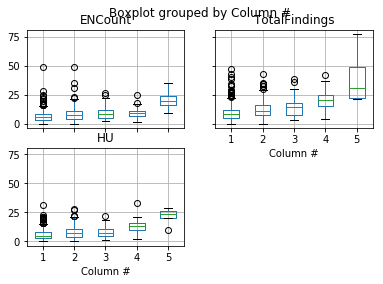

In [174]:
df.boxplot(by = "Column #", column = ["ENCount","TotalFindings", "HU"]);

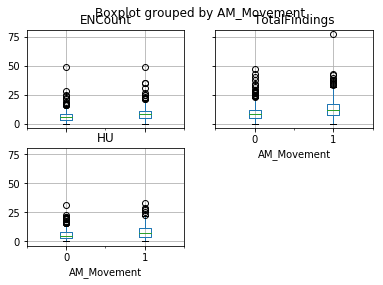

In [366]:
df.boxplot(by = "AM_Movement", column = ["ENCount","TotalFindings", "HU"]);

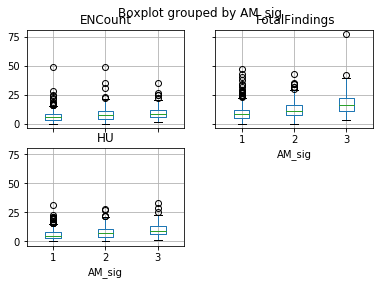

In [176]:
df.boxplot(by = "AM_sig", column = ["ENCount","TotalFindings", "HU"]);

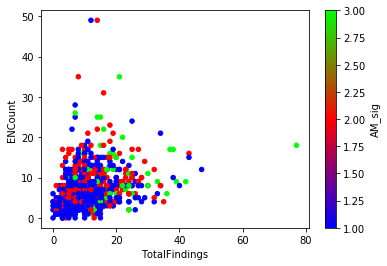

In [367]:
df.plot(kind = "scatter", x = "TotalFindings", y = "ENCount", c = "AM_sig", colormap = "brg");

# K Nearest Neighbors Classification

***KNN for Target Variable with Five Classes***

For the first model, we'll use train_test_split to fit a knn model to the data using the five values in Column # as the five classes for the target variable.  We'll evaluate the model iterating from 1-50 nearest neighbors, then plot the resulting scores to see which value provides the best score when applied to the test data.

In [368]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn import metrics

In [369]:
#start with y = Column #
feature_cols = ["ENCount","ScramCount","TotalFindings","SSFF","HU","PIR"]
X = df[feature_cols]
y = df["Column #"]

In [374]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
score1 = []
for i in range(1,50):
    knn1 = KNeighborsClassifier(n_neighbors = i)
    knn1.fit(X_train, y_train)
    y_pred_class = knn1.predict(X_test)
    scorefit = metrics.accuracy_score(y_test, y_pred_class)
    score1.append([i,scorefit])

34
0.7058823529411765


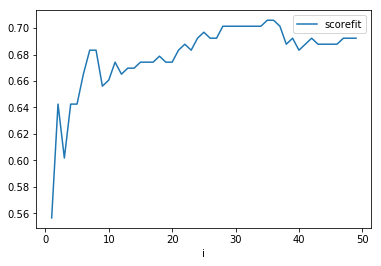

In [375]:
df_scores1 = pd.DataFrame(score1, columns = ["i","scorefit"])
print(df_scores1["scorefit"].argmax())
print(df_scores1["scorefit"].max())
df_scores1.plot.line(x = "i", y = "scorefit");

Next we'll determine what our score would have been in the "null" case, which for this scenario would be assuming the answer is always the most frequent class (column 1), and compare that to the scores obtained by the model.

In [376]:
#compare against the null accuracy
most_freq_class = y_test.value_counts().index[0]
print(y_test.value_counts())
most_freq_class

1    150
2     51
3     15
4      4
5      1
Name: Column #, dtype: int64


1

In [377]:
y_test.value_counts()[most_freq_class]/len(y_test)

0.6787330316742082

Over several runs, the maximum score generally occurs with a k between 20-40 and that particular value outperforms the null accuracy, but not by much.  The model overall does not appear to be a reliable predictor of column number.

One consideration - the parameters have not been scaled.  There is not a huge variation, but in general TotalFindings tends to be an order of magnitude higher than ScramCount.  

***KNN with Scaled Data for Target Variable with Five Classes***

This scenario will also apply a KNN classifier using a target variable with five classes, but this time we'll scale the features to hopefully better harness the strengths of the KNN classifier.

In [378]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [379]:
from sklearn.preprocessing import StandardScaler

In [380]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [381]:
score2 = []
for i in range(1,50):
    knn2 = KNeighborsClassifier(n_neighbors = i)
    knn2.fit(X_train, y_train)
    y_pred_class = knn2.predict(X_test)
    scorefit = metrics.accuracy_score(y_test, y_pred_class)
    score2.append([i,scorefit])

9
0.6832579185520362


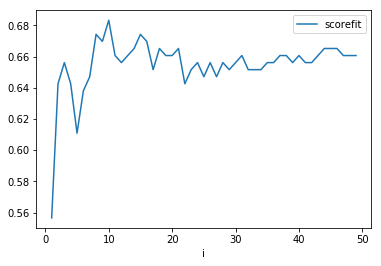

In [382]:
df_scores2 = pd.DataFrame(score2, columns = ["i","scorefit"])
print(df_scores2["scorefit"].argmax())
print(df_scores2["scorefit"].max())
df_scores2.plot.line(x = "i", y = "scorefit");

In [383]:
#compare against the null accuracy
most_freq_class = y_test.value_counts().index[0]
print(y_test.value_counts())
y_test.value_counts()[most_freq_class]/len(y_test)

1    144
2     59
3     13
4      5
Name: Column #, dtype: int64


0.6515837104072398

The performance appears to be marginally improved, but not enough to be consistently more reliable than the null accuracy.

***KNN with Scaled Data for Target Variable with Three Classes***

Because there are so few labels in column 4 and 5, there really isn't enough data to distinguish between predictive performance and random outliers.  One possibility would be to group columns 3, 4, and 5 together as one classification, for a total of 3 classifications: column 1, column 2, and column 3+.  This is given in the AM_sig column of df.

23
0.6787330316742082


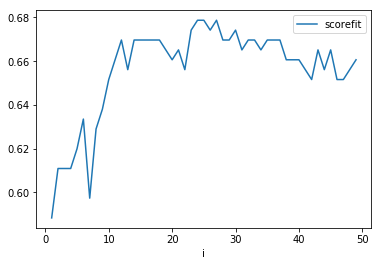

In [386]:
#start with y = AM_sig
#continue to used scaled data
feature_cols = ["ENCount","ScramCount","TotalFindings","SSFF","HU","PIR"]
X = df[feature_cols]
y = df["AM_sig"]
X_train, X_test, y_train, y_test = train_test_split(X,y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

score3 = []
for i in range(1,50):
    knn3 = KNeighborsClassifier(n_neighbors = i)
    knn3.fit(X_train, y_train)
    y_pred_class = knn3.predict(X_test)
    scorefit = metrics.accuracy_score(y_test, y_pred_class)
    score3.append([i,scorefit])
    
df_scores3 = pd.DataFrame(score3, columns = ["i","scorefit"])
print(df_scores3["scorefit"].argmax())
print(df_scores3["scorefit"].max())
df_scores3.plot.line(x = "i", y = "scorefit");

In [387]:
#compare against the null accuracy
most_freq_class = y_test.value_counts().index[0]
print(y_test.value_counts())
y_test.value_counts()[most_freq_class]/len(y_test)

1    145
2     62
3     14
Name: AM_sig, dtype: int64


0.6561085972850679

***KNN with Cross-Validation for Target Variable with Three Classes***

For the scenarios above, we were running the model several times to eyeball the result to get a feeling for how the score would vary depending on how the data was split.  Using k-fold cross validation, we can get a better feeling for where the model score would usually fall.

35
0.6693181818181818


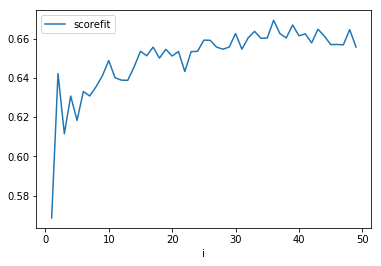

In [388]:
#run k-fold cross-validation to get a better feel for the average performance of the model

kf = model_selection.KFold(n_splits = 10, shuffle = True)

feature_cols = ["ENCount","ScramCount","TotalFindings","SSFF","HU","PIR"]
X = df[feature_cols]
y = df["AM_sig"]

score4 = []

for i in range(1,50):
    acc = []
    n = 0
    for train_index, test_index in kf.split(X,y):
        knn4 = KNeighborsClassifier(n_neighbors = i)
        knn4.fit(X.iloc[train_index],y.iloc[train_index])
        
        acc.append(metrics.accuracy_score(y.iloc[test_index], knn4.predict(X.iloc[test_index])))
        
        n+=1
    scorefit = np.mean(acc)
    score4.append([i,scorefit])

df_scores4 = pd.DataFrame(score4, columns = ["i","scorefit"])
print(df_scores4["scorefit"].argmax())
print(df_scores4["scorefit"].max())
df_scores4.plot.line(x = "i", y = "scorefit");

Even combining the highest three columns into one class hasn't produced a result that is reliably even marginally better than the null accuracy.  

***KNN with Cross-Validation for Target Variable with Two Classes***

The number of rows for each of the classes above are still highly unbalanced.  The next model will group the data into just two classes - Column # = 1 and Column # >1.  This is given by a 0 or a 1 in the AM_Movement column. 

40
0.6931307456588356


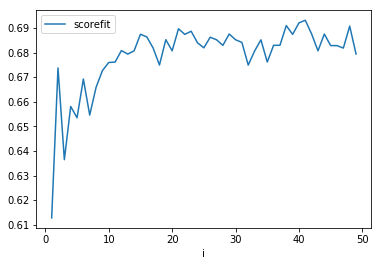

In [389]:
#Use "AM_Movement" column as the target variable and perform k-folds cross-validation on a knn model for k in range(1,50)
kf = model_selection.KFold(n_splits = 10, shuffle = True)

feature_cols = ["ENCount","ScramCount","TotalFindings","SSFF","HU","PIR"]
X = df[feature_cols]
y = df["AM_Movement"]

score5 = []

for i in range(1,50):
    acc = []
    n = 0
    for train_index, test_index in kf.split(X,y):
        knn5 = KNeighborsClassifier(n_neighbors = i)
        knn5.fit(X.iloc[train_index],y.iloc[train_index])
        
        acc.append(metrics.accuracy_score(y.iloc[test_index], knn5.predict(X.iloc[test_index])))
        
        n+=1
    scorefit = np.mean(acc)
    score5.append([i,scorefit])

df_scores5 = pd.DataFrame(score5, columns = ["i","scorefit"])
print(df_scores5["scorefit"].argmax())
print(df_scores5["scorefit"].max())
df_scores5.plot.line(x = "i", y = "scorefit");

This appears to be slightly better than when there were 3 or 5 classes.  The KNN model is highly susceptible to outliers though.  There are known outliers in the data for reasons that are unrelated to overall performance (column #); one option for future exploration could be to level the outlier points to more appropriate values and see if that improves the performance.  

# Logistic Regression

Instead, using just the two classes given by using AM_Movement as the target variable, we'll try applying a logistic regression model, which might be better suited to a dataset with these types of outliers. 

In [390]:
from sklearn.linear_model import LogisticRegression

In [391]:
kf = model_selection.KFold(n_splits = 10, shuffle = True)

feature_cols = ["ENCount","ScramCount","TotalFindings","SSFF","HU","PIR"]
X = df[feature_cols]
y = df["AM_Movement"]

acc = []

n = 0
for train_index, test_index in kf.split(X,y):
    logreg = LogisticRegression()
    logreg.fit(X.iloc[train_index],y.iloc[train_index])
        
    acc.append(logreg.score(X.iloc[test_index], y.iloc[test_index]))
        
    n+=1
scorefit = np.mean(acc)

print(scorefit)


0.7043539325842697


In [392]:
#compare with the null accuracy (proportion of the majority class label)
1-y.mean()

0.6557191392978483

The logistic regression model appears to reliably predict the target variable better than just assuming the majority class label, matching the best performance of a knn-model that would be difficult to meaningfully apply to new data.

Compute a confusion matrix to get a feel for false positives (plants with predicted AM movement that did not move) vs. false negatives (plants not predicted to have AM movement that did in fact move).

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
logreg2 = LogisticRegression()
logreg2.fit(X_train, y_train)

print(f"The baseline accuracy is {1-y_train.mean()}")

print(f"The accuracy of the model on the test set is {np.mean(y_test == logreg2.predict(X_test))}")

logreg2_pred_proba = logreg2.predict_proba(X_test)[:,1]

tn, fp, fn, tp = metrics.confusion_matrix(y_true = y_test, y_pred = logreg2_pred_proba > .5).ravel()
(tn, fp, fn, tp)

The baseline accuracy is 0.6525679758308157
The accuracy of the model on the test set is 0.7194570135746606


(135, 12, 50, 24)

The model has more false negatives than false positives, which is probably preferable given the business scenario.  However, the false negative rate runs almost 2-3 times the true postitive rate, indicating limited usefulness.  The next scenario will try to improve the outcome by limiting the feature columns to HU, which appears from a scatter plot to have a better fit for the logistic regression function.

***Logistic Regression with One Feature Column***

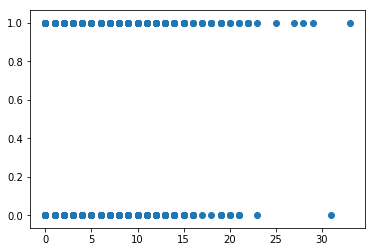

In [396]:
plt.scatter( df.HU, df.AM_Movement);

In [399]:
feature_cols = ["HU"]
X = df[feature_cols]
y = df["AM_Movement"]

X_train, X_test, y_train, y_test = train_test_split(X,y)
logreg3 = LogisticRegression()
logreg3.fit(X_train, y_train)

print(f"The baseline accuracy is {1-y_train.mean()}")

print(f"The accuracy of the model on the test set is {np.mean(y_test == logreg3.predict(X_test))}")

logreg3_pred_proba = logreg3.predict_proba(X_test)[:,1]

tn, fp, fn, tp = metrics.confusion_matrix(y_true = y_test, y_pred = logreg3_pred_proba > .5).ravel()
(tn, fp, fn, tp)

The baseline accuracy is 0.6601208459214502
The accuracy of the model on the test set is 0.6289592760180995


(127, 15, 67, 12)

Even though the HU feature best maps to a logistic regression distribution, the model performed much better when the other columns were also considered. With only HU, it consistently does not even match the accuracy of the majority case "null" model.

Given the high dependence among HU, TotalFindings, and PIR, would the model work better if it only considered one of these features?

***Logistic Regression with Four Feature Columns***

In [405]:
feature_cols = ["ENCount", "ScramCount", "TotalFindings", "SSFF"]
X = df[feature_cols]
y = df["AM_Movement"]

X_train, X_test, y_train, y_test = train_test_split(X,y)
logreg4 = LogisticRegression()
logreg4.fit(X_train, y_train)

print(f"The baseline accuracy is {1-y_train.mean()}")

print(f"The accuracy of the model on the test set is {np.mean(y_test == logreg4.predict(X_test))}")

logreg4_pred_proba = logreg4.predict_proba(X_test)[:,1]

tn, fp, fn, tp = metrics.confusion_matrix(y_true = y_test, y_pred = logreg4_pred_proba > .5).ravel()
(tn, fp, fn, tp)

The baseline accuracy is 0.6555891238670695
The accuracy of the model on the test set is 0.6832579185520362


(127, 18, 52, 24)

This is an improvement over just using HU. To get a better idea of its effectiveness compared to the model using all the feature columns, we'll run a cross-validation with 10 splits on the model with 4 feature columns.

In [406]:
kf = model_selection.KFold(n_splits = 10, shuffle = True)

feature_cols = ["ENCount","ScramCount","TotalFindings","SSFF"]
X = df[feature_cols]
y = df["AM_Movement"]

acc = []

n = 0
for train_index, test_index in kf.split(X,y):
    logreg5 = LogisticRegression()
    logreg5.fit(X.iloc[train_index],y.iloc[train_index])
        
    acc.append(logreg5.score(X.iloc[test_index], y.iloc[test_index]))
        
    n+=1
scorefit = np.mean(acc)

print(scorefit)

0.7067415730337079


The score for using four feature columns is roughly the same as the score using six; it does not appear that any information was lost by dropping the HU and PIR columns.

# Random Forest

A Random Forest model may allow us to both more easily correct for the unbalanced distribution of the target variable and get an idea for which features are most important in the classification.  A future exploration might then use this to better address known outliers.

In [407]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [408]:
feature_cols = ["ENCount", "ScramCount", "TotalFindings", "HU", "PIR", "SSFF"]
X = df[feature_cols]
y = df["AM_Movement"]

X_train, X_test, y_train, y_test = train_test_split(X,y)


In [409]:
#handle the unbalanced distribution for the target variable
y_train.value_counts()

0    432
1    230
Name: AM_Movement, dtype: int64

In [410]:
imbalance = y_train.value_counts().loc[0]/y_train.value_counts().loc[1]
weight = int(round(imbalance))

class_wgt = {1:weight, 0:1}

In [411]:
rf = RandomForestClassifier(n_estimators = 150, max_features = 5, oob_score = True, random_state = 1, class_weight = class_wgt)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 2, 0: 1},
            criterion='gini', max_depth=None, max_features=5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [412]:
pd.DataFrame({"feature": X_train.columns.values, 
              "importance": rf.feature_importances_}).sort_values(by ="importance", ascending = False)

,feature,importance
0,ENCount,0.234677
2,TotalFindings,0.233757
3,HU,0.189854
4,PIR,0.134309
5,SSFF,0.111677
1,ScramCount,0.095726


In [413]:
print("OOB accuracy score = " , rf.oob_score_)
print("Training data accuracy = " , rf.score(X_train, y_train))
print("Testing data accuracy = " , rf.score(X_test, y_test))

OOB accuracy score =  0.676737160120846
Training data accuracy =  0.9969788519637462
Testing data accuracy =  0.6470588235294118


This model clearly suffers from over-fitting. Examine what happens from first reducing max_features, and then reducing the number of features considered.

***Random Forest: Reduce max_features to Three***

In [414]:
feature_cols = ["ENCount", "ScramCount", "TotalFindings", "HU", "PIR", "SSFF"]
X = df[feature_cols]
y = df["AM_Movement"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

imbalance = y_train.value_counts().loc[0]/y_train.value_counts().loc[1]
weight = int(round(imbalance))

class_wgt = {1:weight, 0:1}

rf2 = RandomForestClassifier(n_estimators = 150, max_features = 3, oob_score = True, random_state = 1, class_weight = class_wgt)

rf2.fit(X_train, y_train)

print("OOB accuracy score = " , rf2.oob_score_)
print("Training data accuracy = " , rf2.score(X_train, y_train))
print("Testing data accuracy = " , rf2.score(X_test, y_test))

pd.DataFrame({"feature": X_train.columns.values, 
              "importance": rf2.feature_importances_}).sort_values(by ="importance", ascending = False)

OOB accuracy score =  0.6601208459214502
Training data accuracy =  0.9969788519637462
Testing data accuracy =  0.6470588235294118


,feature,importance
2,TotalFindings,0.247191
0,ENCount,0.203558
3,HU,0.189992
4,PIR,0.142948
5,SSFF,0.124290
1,ScramCount,0.092022


Reducing max_features didn't address the over-fitting issue.  Let's see what happens when we limit the features considered to just the top three.   

***Random Forest with Three Feature Columns**

In [415]:
feature_cols = ["ENCount", "TotalFindings", "HU"]
X = df[feature_cols]
y = df["AM_Movement"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

imbalance = y_train.value_counts().loc[0]/y_train.value_counts().loc[1]
weight = int(round(imbalance))

class_wgt = {1:weight, 0:1}

rf3 = RandomForestClassifier(n_estimators = 150, max_features = 3, oob_score = True, random_state = 1, class_weight = class_wgt)

rf3.fit(X_train, y_train)

print("OOB accuracy score = " , rf3.oob_score_)
print("Training data accuracy = " , rf3.score(X_train, y_train))
print("Testing data accuracy = " , rf3.score(X_test, y_test))

pd.DataFrame({"feature": X_train.columns.values, 
              "importance": rf3.feature_importances_}).sort_values(by ="importance", ascending = False)

OOB accuracy score =  0.5845921450151057
Training data accuracy =  0.945619335347432
Testing data accuracy =  0.6018099547511312


,feature,importance
1,TotalFindings,0.356741
0,ENCount,0.327969
2,HU,0.315290


This reduced the over-fitting issue, but at the expense of reducing the overall accuracy.  The final look will examine whether it's possible to better tune the hyperparameters.

***Random Forest: Tune Hyperparameters***

In [416]:
from sklearn.model_selection import RandomizedSearchCV

In [417]:
feature_cols = ["ENCount", "ScramCount", "TotalFindings", "HU", "PIR", "SSFF"]
X = df[feature_cols]
y = df["AM_Movement"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 5)]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(3,20, num = 5)]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

random_grid = {"n_estimators":n_estimators,
              "max_features":max_features,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "bootstrap":bootstrap}

rf4 = RandomForestClassifier()

rf4_random = RandomizedSearchCV(estimator = rf4, n_jobs = -1, 
                              param_distributions = random_grid,
                              n_iter = 50, cv = 2, verbose = 10, scoring = "accuracy")

rf4_random.fit(X_train, y_train)

rf4_random.best_params_

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.6s finished


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 3,
 'bootstrap': True}

In [418]:
imbalance = y_train.value_counts().loc[0]/y_train.value_counts().loc[1]
weight = int(round(imbalance))

class_wgt = {1:weight, 0:1}

rf5 = RandomForestClassifier(**rf4_random.best_params_, class_weight = class_wgt)

rf5.fit(X_train, y_train)
y_pred = rf5.predict(X_test)

print("Accuracy Score = %.2f" %metrics.accuracy_score(y_test, y_pred))

Accuracy Score = 0.64


The random forest does not appear to be a great model for this data.

# Conclusion

The feature columns with the data provided do not seem to provide the information necessary to reliably predict plant performance as determined by "Column #," at least at the fundamental level used in the application of three different classification models here. 

*Possible Considerations Going Forward*

There are known outliers in the data where the inputs are known to be unrelated to current overall performance.  Using business-case-specific knowledge, some of these outliers could be replaced with more representative values.

Applying a cluster model may reveal that the classifications assigned by the program are inadequate - perhaps 6 or 8 classifications,particularly if they picked out differences in performance among the Column 1 plants - would improve performance among some of the models used above.

In a similar vein, there are gradations within the feature columns - some ENs or Scrams or Findings are more reflective of potential developing problems than others.  If the feature columns were further broken out to capture this data, it might help better distinguish plants with poorer performance.  This would require significant interface with those knowledgeable with the underlying issues captured by the data.

There are underlying trends influencing all of the data over time that are not necessarily reflective of overall performance.  Subtracting out the times-series trend contribution would allow for better apples-to-apples comparison across time of each of the parameters and could improve model performance.  
